In [1]:
%matplotlib inline
import pylab as plt
import numpy as np
import sys
import os
import logging
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import LinearNDInterpolator
from scipy.optimize import minimize

In [2]:
home = os.environ['HOME']
sys.path.insert(0, home + '/astrometry')

In [3]:
from astrometry.util.fits import *
from astrometry.util.plotutils import *

In [4]:
times = [900, 1800, 3600, 7200, 14400]
mags = np.arange(20.0, 24.01, 0.25)
Z = {}
for exptime in times:
    for mag in mags:
        tag = 'mag%.2f-t%i' % (mag, exptime)
        zfn = 'zbest-%s.fits' % tag
        if not os.path.exists(zfn):
            continue
        infn = 'input-%s.fits' % tag
        z = fits_table(zfn)
        inp = fits_table(infn)
        z.ztrue = inp.redshift
        Z[(exptime,mag)] = z
print(len(Z), 'results')

32 results


For exposure time 900 and   all galaxies we get 90% success at mag 21.79
For exposure time 900 and   red galaxies we get 90% success at mag 21.79
For exposure time 900 and green galaxies we get 90% success at mag 21.58
For exposure time 900 and  blue galaxies we get 90% success at mag 22.21


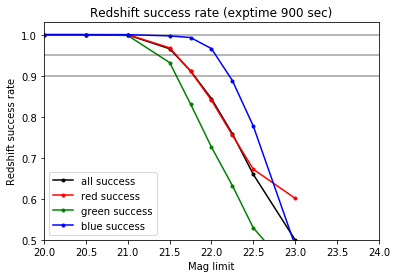

For exposure time 1800 and   all galaxies we get 90% success at mag 22.31
For exposure time 1800 and   red galaxies we get 90% success at mag 22.26
For exposure time 1800 and green galaxies we get 90% success at mag 22.14
For exposure time 1800 and  blue galaxies we get 90% success at mag 22.68


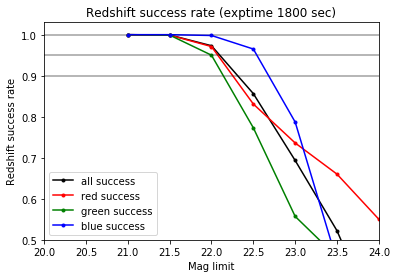

For exposure time 3600 and   all galaxies we get 90% success at mag 22.77
For exposure time 3600 and   red galaxies we get 90% success at mag 22.79
For exposure time 3600 and green galaxies we get 90% success at mag 22.60
For exposure time 3600 and  blue galaxies we get 90% success at mag 23.12


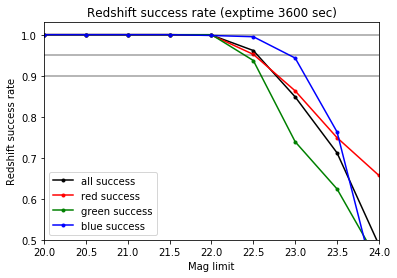

For exposure time 7200 and   all galaxies we get 90% success at mag 23.23
For exposure time 7200 and   red galaxies we get 90% success at mag 23.29
For exposure time 7200 and green galaxies we get 90% success at mag 22.98
For exposure time 7200 and  blue galaxies we get 90% success at mag 23.53


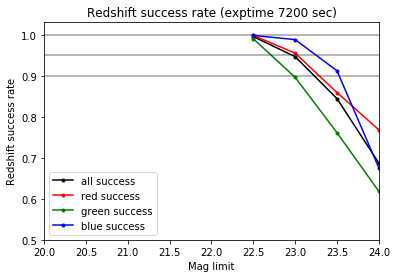

For exposure time 14400 and   all galaxies we get 90% success at mag 23.65
For exposure time 14400 and   red galaxies we get 90% success at mag 23.73
For exposure time 14400 and green galaxies we get 90% success at mag 23.44
For exposure time 14400 and  blue galaxies we get 90% success at mag 23.83


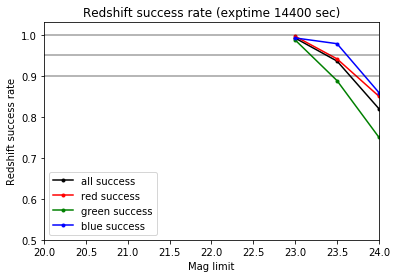

In [5]:
m90s = {}
for it,t in enumerate(times):
    success_all = np.zeros(len(mags))
    success_r = np.zeros(len(mags))
    success_g = np.zeros(len(mags))
    success_b = np.zeros(len(mags))
    correct_all = np.zeros(len(mags))
    correct_r = np.zeros(len(mags))
    correct_g = np.zeros(len(mags))
    correct_b = np.zeros(len(mags))
    for i,m in enumerate(mags):
        try:
            z = Z[(t,m)]
        except KeyError:
            continue
            
        #z.success = (z.zwarn == 0) * (z.deltachi2 > 40.0)
        z.success = (z.zwarn == 0) * (z.deltachi2 > 9.0)
        #z.success = (z.zwarn == 0) * (z.deltachi2 > 4.0)
            
        success_all[i] = np.mean(z.success)
        success_r[i] = np.mean(z.success[0:1000])
        success_g[i] = np.mean(z.success[1000:2000])
        success_b[i] = np.mean(z.success[2000:3000])
        
        z.correct = (np.abs((z.z - z.ztrue) / (1. + z.ztrue)) < 0.003)

        correct_all[i] = np.mean(z.correct)
        correct_r[i] = np.mean(z.correct[0:1000])
        correct_g[i] = np.mean(z.correct[1000:2000])
        correct_b[i] = np.mean(z.correct[2000:3000])
        
    #for samp,success in [('all', success_all), ('red', success_r), ('green', success_g), ('blue', success_b)]:
    #    plt.clf()
    #    I = np.flatnonzero(success > 0)
    #    plt.plot(mags[I], success[I], '-')
    #    plt.xlabel('Mag limit')
    #    plt.ylabel('Success rate')
    #    plt.title('Exposure time %i sec, %s galaxies' % (t, samp))
    #    plt.show()

    # At what mag does *success* pass *thresh*?
    thresh = 0.9
    for samp,success,correct in [
         ('all', success_all, correct_all),
         ('red', success_r, correct_r),
         ('green', success_g, correct_g),
         ('blue', success_b, correct_b)]:
        I = np.flatnonzero(success > 0)
        f = InterpolatedUnivariateSpline(mags[I], success[I], k=1)
        M = np.linspace(mags[I[0]], mags[I[-1]], 500)
        d = np.abs(f(M) - thresh)
        ii = np.argmin(d)
        m90 = M[ii]
        m90s[(samp,t)] = m90
        print('For exposure time', t, 'and %5s galaxies we get 90%% success at mag %.2f' % (samp,m90))
    
    plt.figure(figsize=(6,4))
    plt.clf()
    for samp,success,correct in [
         ('all', success_all, correct_all),
         ('red', success_r, correct_r),
         ('green', success_g, correct_g),
         ('blue', success_b, correct_b)]:
        I = np.flatnonzero(success > 0)
        #plt.subplot(1,2,1)
        plt.plot(mags[I], success[I], '.-', label=samp + ' success', color={'all':'k'}.get(samp,samp))
        #plt.plot(mags[I], correct[I], '--', label=samp + ' correct', color={'all':'k'}.get(samp,samp))
        plt.xlabel('Mag limit')
        plt.ylabel('Redshift success rate')
        plt.title('Redshift success rate (exptime %i sec)' % t)
        plt.ylim(0.5, 1.03)
        plt.xlim(mags[0], mags[-1])
        plt.axhline(1.00, color='k', alpha=0.1)
        plt.axhline(0.95, color='k', alpha=0.1)
        plt.axhline(0.90, color='k', alpha=0.1)
        #plt.axvline(m90, color='k', alpha=0.1)
        
    #plt.xlim(20.5, 23.0)
    plt.legend()
    plt.savefig('%i.png' % (it+1))
    plt.show()
        
        

In [6]:
m90s

{('all', 900): 21.791583166332664,
 ('red', 900): 21.791583166332664,
 ('green', 900): 21.5811623246493,
 ('blue', 900): 22.2124248496994,
 ('all', 1800): 22.31062124248497,
 ('red', 1800): 22.256513026052104,
 ('green', 1800): 22.142284569138276,
 ('blue', 1800): 22.683366733466933,
 ('all', 3600): 22.773547094188377,
 ('red', 3600): 22.789579158316634,
 ('green', 3600): 22.597194388777556,
 ('blue', 3600): 23.118236472945892,
 ('all', 7200): 23.227454909819638,
 ('red', 7200): 23.2875751503006,
 ('green', 7200): 22.977955911823646,
 ('blue', 7200): 23.5250501002004,
 ('all', 14400): 23.65330661322645,
 ('red', 14400): 23.725450901803608,
 ('green', 14400): 23.438877755511022,
 ('blue', 14400): 23.827655310621243}

In [7]:
for t in times:
    print('For exposure time % 6i sec we get 90%% redshift success at mag %.2f' % (t, m90s[('all',t)]))


For exposure time    900 sec we get 90% redshift success at mag 21.79
For exposure time   1800 sec we get 90% redshift success at mag 22.31
For exposure time   3600 sec we get 90% redshift success at mag 22.77
For exposure time   7200 sec we get 90% redshift success at mag 23.23
For exposure time  14400 sec we get 90% redshift success at mag 23.65


In [8]:
for t in times:
    print('For exposure time % 6i sec we get 90%% redshift success at mag %.2f / %.2f / %.2f for green / red / blue galaxies'
          % (t, m90s[('green',t)], m90s[('red',t)], m90s[('blue',t)]))

For exposure time    900 sec we get 90% redshift success at mag 21.58 / 21.79 / 22.21 for green / red / blue galaxies
For exposure time   1800 sec we get 90% redshift success at mag 22.14 / 22.26 / 22.68 for green / red / blue galaxies
For exposure time   3600 sec we get 90% redshift success at mag 22.60 / 22.79 / 23.12 for green / red / blue galaxies
For exposure time   7200 sec we get 90% redshift success at mag 22.98 / 23.29 / 23.53 for green / red / blue galaxies
For exposure time  14400 sec we get 90% redshift success at mag 23.44 / 23.73 / 23.83 for green / red / blue galaxies


In [9]:
repr(m90s)

"{('all', 900): 21.791583166332664, ('red', 900): 21.791583166332664, ('green', 900): 21.5811623246493, ('blue', 900): 22.2124248496994, ('all', 1800): 22.31062124248497, ('red', 1800): 22.256513026052104, ('green', 1800): 22.142284569138276, ('blue', 1800): 22.683366733466933, ('all', 3600): 22.773547094188377, ('red', 3600): 22.789579158316634, ('green', 3600): 22.597194388777556, ('blue', 3600): 23.118236472945892, ('all', 7200): 23.227454909819638, ('red', 7200): 23.2875751503006, ('green', 7200): 22.977955911823646, ('blue', 7200): 23.5250501002004, ('all', 14400): 23.65330661322645, ('red', 14400): 23.725450901803608, ('green', 14400): 23.438877755511022, ('blue', 14400): 23.827655310621243}"

In [10]:
from speclite.filters import *
from desisim.templates import BGS
from astropy.table import Table

In [11]:
filters = load_filters('decam2014-g', 'decam2014-r', 'decam2014-z')

In [12]:
os.environ['DESI_BASIS_TEMPLATES'] = '/gpfs/dlang/desi/spectro/templates/basis_templates/v3.2/'
#os.environ['DESIMODEL'] = home + '/desicode/desimodel-data/0.13.1'
#os.environ['RR_TEMPLATE_DIR'] = home + '/desicode/redrock-templates'
#os.environ['OMP_NUM_THREADS'] = '1'

In [13]:
input_meta = Table.read('input-mag24.00-t7200.fits')

In [14]:
input_meta['MAGFILTER'] = input_meta['MAGFILTER'].astype(str)

In [15]:
flux, wave, bmeta, objmeta = BGS().make_templates(input_meta=input_meta[::10], nocolorcuts=True)

INFO:io.py:971:read_basis_templates: Reading /gpfs/dlang/desi/spectro/templates/basis_templates/v3.2/bgs_templates_v2.3.fits


In [16]:
wave.shape

(32001,)

In [17]:
(padflux,padwave) = filters.pad_spectrum(flux, wave, method='zero')
mags = filters.get_ab_magnitudes(padflux  * 1e-17 * default_flux_unit, wavelength=padwave)

In [18]:
mags

decam2014-g,decam2014-r,decam2014-z
float64,float64,float64
26.137038099081327,24.00094251742411,22.01175036567213
25.8671326857488,24.000008529722404,22.95538469290406
25.660107792180664,23.999991887188944,23.09315862868958
26.151820971423806,24.00074345691157,21.938228394123257
25.423486829585592,23.999909831626876,23.24728812555946
25.629231655840567,24.00427882071408,21.151354136238506
26.481370718819186,24.002019865214553,21.53574171385611
25.145943896819727,23.999941813305146,23.330260167571968
26.63510918852799,24.001726154056726,21.596157244901452


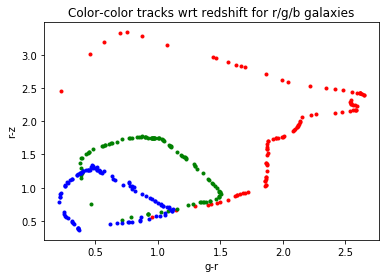

In [22]:
I = slice(0,100)
plt.plot((mags['decam2014-g']-mags['decam2014-r'])[I], (mags['decam2014-r']-mags['decam2014-z'])[I],
            'r.');
I = slice(100,200)
plt.plot((mags['decam2014-g']-mags['decam2014-r'])[I], (mags['decam2014-r']-mags['decam2014-z'])[I],
            'g.');
I = slice(200,300)
plt.plot((mags['decam2014-g']-mags['decam2014-r'])[I], (mags['decam2014-r']-mags['decam2014-z'])[I],
            'b.');
plt.xlabel('g-r')
plt.ylabel('r-z')
plt.title('Color-color tracks wrt redshift for r/g/b galaxies');

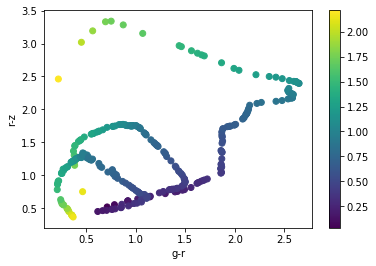

In [23]:
plt.scatter(mags['decam2014-g']-mags['decam2014-r'], mags['decam2014-r']-mags['decam2014-z'],
            c=input_meta[::10]['REDSHIFT']);
plt.xlabel('g-r')
plt.ylabel('r-z')
plt.colorbar();

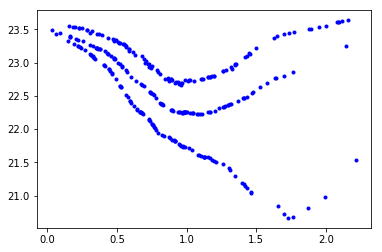

In [24]:
plt.plot(input_meta[::10]['REDSHIFT'], mags['decam2014-z'], 'b.');